In [1]:
import math
from typing import Optional, Tuple, Any
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import Dataset, DataLoader
import einops

In [2]:
#kxin--数据预处理
class StrokesDataset(Dataset):


    def __init__(self, dataset: np.array, max_seq_length: int, scale: Optional[float] = None):
        data = []
        #过滤序列长度过大的
        for seq in dataset:
            if 10 < len(seq) <= max_seq_length:
                seq = np.minimum(seq, 1000)
                seq = np.maximum(seq, -1000)
                seq = np.array(seq, dtype=np.float32)
                data.append(seq)


        if scale is None:
            scale = np.std(np.concatenate([np.ravel(s[:, 0:2]) for s in data]))
        self.scale = scale


        #kxin--保存序列最大长度统一数据维度数
        longest_seq_len = max([len(seq) for seq in data])

        #初始化data和mask
        self.data = torch.zeros(len(data), longest_seq_len + 2, 5, dtype=torch.float)

        self.mask = torch.zeros(len(data), longest_seq_len + 1)


        #kxin--处理数据
        for i, seq in enumerate(data):
            seq = torch.from_numpy(seq)
            len_seq = len(seq)

            self.data[i, 1:len_seq + 1, :2] = seq[:, :2] / scale

            self.data[i, 1:len_seq + 1, 2] = 1 - seq[:, 2]

            self.data[i, 1:len_seq + 1, 3] = seq[:, 2]

            self.data[i, len_seq + 1:, 4] = 1

            self.mask[i, :len_seq + 1] = 1
        self.data[:, 0, 2] = 1

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx: int):

        return self.data[idx], self.mask[idx]

In [3]:
#kxin--描述混合高斯的工具类，返回多个二元高斯分布和分类分布
class BivariateGaussianMixture(object):
    def __init__(self, pi_logits: torch.Tensor, mu_x: torch.Tensor, mu_y: torch.Tensor,
                 sigma_x: torch.Tensor, sigma_y: torch.Tensor, rho_xy: torch.Tensor):
        self.pi_logits = pi_logits
        self.mu_x = mu_x
        self.mu_y = mu_y
        self.kxin = 'kxin'
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho_xy = rho_xy

    @property
    def n_distributions(self):
        return self.pi_logits.shape[-1]

    #利用温度控制模型相关参数,控制随机性
    def set_temperature(self, temperature: float):
        self.pi_logits /= temperature
        self.sigma_x *= math.sqrt(temperature)
        self.sigma_y *= math.sqrt(temperature)

    #kxin--利用传入的参数，返回多个二元高斯分布和分类分布
    def get_distribution(self):
        sigma_x = torch.clamp_min(self.sigma_x, 1e-5)
        sigma_y = torch.clamp_min(self.sigma_y, 1e-5)
        rho_xy = torch.clamp(self.rho_xy, -1 + 1e-5, 1 - 1e-5)
        mean = torch.stack([self.mu_x, self.mu_y], -1)
       
        cov = torch.stack([
            sigma_x * sigma_x, rho_xy * sigma_x * sigma_y,
            rho_xy * sigma_x * sigma_y, sigma_y * sigma_y
        ], -1)
        cov = cov.view(*sigma_y.shape, 2, 2)

        multi_dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
        cat_dist = torch.distributions.Categorical(logits=self.pi_logits)

        return cat_dist, multi_dist

In [4]:
#编码器
class EncoderRNN(nn.Module):
    def __init__(self, d_z: int, enc_hidden_size: int):
        super().__init__()
        #将bidirectional设置为True，实现双向RNN
        self.lstm = nn.LSTM(5, enc_hidden_size, bidirectional=True)
        self.mu_head = nn.Linear(2 * enc_hidden_size, d_z)
        self.sigma_head = nn.Linear(2 * enc_hidden_size, d_z)

    def forward(self, inputs: torch.Tensor, state=None):
        _, (hidden, cell) = self.lstm(inputs.float(), state)
        hidden = einops.rearrange(hidden, 'fb b h -> b (fb h)')
        #通过线性层，生成mu
        mu = self.mu_head(hidden)
        #通过线性层，生成sigma_hat
        sigma_hat = self.sigma_head(hidden)
        sigma = torch.exp(sigma_hat / 2.)

        #随机采样，计算z
        z = mu + sigma * torch.normal(mu.new_zeros(mu.shape), mu.new_ones(mu.shape))
        return z, mu, sigma_hat


In [5]:
#kxin--解码器
class DecoderRNN(nn.Module):
    def __init__(self, d_z: int, dec_hidden_size: int, n_distributions: int):
        super().__init__()
        #定义RNN
        self.lstm = nn.LSTM(d_z + 5, dec_hidden_size)
        self.init_state = nn.Linear(d_z, 2 * dec_hidden_size)
        self.mixtures = nn.Linear(dec_hidden_size, 6 * n_distributions)
        self.q_head = nn.Linear(dec_hidden_size, 3)
        self.q_log_softmax = nn.LogSoftmax(-1)
        self.n_distributions = n_distributions
        self.dec_hidden_size = dec_hidden_size

    def forward(self, x: torch.Tensor, z: torch.Tensor, state: Optional[Tuple[torch.Tensor, torch.Tensor]]):
        #通过tanh(z)初始化state0
        if state is None:
            h, c = torch.split(torch.tanh(self.init_state(z)), self.dec_hidden_size, 1)
            state = (h.unsqueeze(0).contiguous(), c.unsqueeze(0).contiguous())

        outputs, state = self.lstm(x, state)

        #kxin--通过线性层和softmax，生成q1,q2,q3
        q_logits = self.q_log_softmax(self.q_head(outputs))

        #通过线性层生成混合高斯对应参数，
        pi_logits, mu_x, mu_y, sigma_x, sigma_y, rho_xy = \
        torch.split(self.mixtures(outputs), self.n_distributions, 2)

        #将混合高斯参数传入工具类,得到torch中的MultivariateNormal, 和Categorical对象方便后续取样和其他操作。
        dist = BivariateGaussianMixture(pi_logits, mu_x, mu_y,
                                        torch.exp(sigma_x), torch.exp(sigma_y), torch.tanh(rho_xy))

        return dist, q_logits, state

In [6]:
#计算Rloss,包含对x, y的loss_s和对p1,p2,p3的loss_p
class ReconstructionLoss(nn.Module):
    def forward(self, mask: torch.Tensor, target: torch.Tensor,
                 dist: 'BivariateGaussianMixture', q_logits: torch.Tensor):

        #计算loss_s
        pi, mix = dist.get_distribution()
        xy = target[:, :, 0:2].unsqueeze(-2).expand(-1, -1, dist.n_distributions, -1)
        probs = torch.sum(pi.probs * torch.exp(mix.log_prob(xy)), 2)
        loss_stroke = -torch.mean(mask * torch.log(1e-5 + probs))

        #kxin--计算lossp
        loss_pen = -torch.mean(target[:, :, 2:] * q_logits)

        return loss_stroke + loss_pen

In [7]:
#计算KLloss
class KLDivLoss(nn.Module):
    def forward(self, sigma_hat: torch.Tensor, mu: torch.Tensor):
        #直接抄公式
        return -0.5 * torch.mean(1 + sigma_hat - mu ** 2 - torch.exp(sigma_hat))

In [8]:
#验证集采样画图辅助类
class Sampler(object):
    def __init__(self, encoder: EncoderRNN, decoder: DecoderRNN):
        self.decoder = decoder
        self.encoder = encoder
    #运行模型编码，解码，最后画图
    def sample(self, data: torch.Tensor, temperature: float,dataName, epoch, batch_index, loss):
        longest_seq_len = len(data)

        #==========编码
        z, _, _ = self.encoder(data)

        s = data.new_tensor([0, 0, 1, 0, 0])
        seq = [s]
        state = None
        
        #==========解码
        #kxin-- 验证画图时不需要梯度跟新
        with torch.no_grad():
            for i in range(longest_seq_len):
                data = torch.cat([s.view(1, 1, -1), z.unsqueeze(0)], 2)
                dist, q_logits, state = self.decoder(data, z, state)
            
                s = self._sample_step(dist, q_logits, temperature)
                seq.append(s)
                # 如果p3为1则停笔
                if s[4] == 1:
                    break

        seq = torch.stack(seq)
        #调用画图工具方法
        self.plot(seq,dataName, epoch, batch_index,loss)

    #工具方法，对预测出的模型进行数据采样和格式的封装。
    def _sample_step(self,dist: 'BivariateGaussianMixture', q_logits: torch.Tensor, temperature: float):
        dist.set_temperature(temperature)
        pi, mix = dist.get_distribution()
        idx = pi.sample()[0, 0]

        q = torch.distributions.Categorical(logits=q_logits / temperature)
        
        q_idx = q.sample()[0, 0]
        xy = mix.sample()[0, 0, idx]

        stroke = q_logits.new_zeros(5)
        stroke[:2] = xy
        stroke[q_idx + 2] = 1
        return stroke

    #kxin--工具方法，画图
    def plot(self,seq: torch.Tensor,dataName, epoch, batch_index, loss):
        seq[:, 0:2] = torch.cumsum(seq[:, 0:2], dim=0)
        seq[:, 2] = seq[:, 3]
        seq = seq[:, 0:3].detach().cpu().numpy()

        strokes = np.split(seq, np.where(seq[:, 2] > 0)[0] + 1)
        plt.figure(figsize=(2,2))
        for s in strokes:
            plt.plot(s[:, 0], -s[:, 1])
        plt.title(f'==kxin_{dataName }==, Epoch {epoch}, Batch {batch_index}, Loss {loss:.5f}',fontsize=10) 
        plt.axis('off')
        plt.show()

In [13]:
#训练器
class Trainer(object):
    device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu")
    kxin = './kxin/'
    #注意修改数据路径
    path = './data/'

    enc_hidden_size = 256
    dec_hidden_size = 512

    batch_size = 200

    d_z = 128
    n_distributions = 20

    kl_div_loss_weight = 0.5
    grad_clip = 1.
    temperature = 0.4

    max_seq_length = 200

    epochs = 25

    lr = 1e-3

    kl_div_loss = KLDivLoss()
    reconstruction_loss = ReconstructionLoss()

    def __init__(self, dataName):
        # =======初始化 encoder 和 decoder
        self.encoder = EncoderRNN(self.d_z, self.enc_hidden_size).to(self.device)
        self.decoder = DecoderRNN(self.d_z, self.dec_hidden_size, self.n_distributions).to(self.device)

        #kxin-- =======设置优化器,将模型参数传入
        parameters = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = optim.Adam(parameters, lr = self.lr)



        # =======创建样例工具类
        self.sampler = Sampler(self.encoder, self.decoder)

       
        #=======创建数据集
        self.dataName = dataName
        self.path += dataName+'.npz'
        # 加载数据集
        dataset = np.load(str(self.path), encoding='latin1', allow_pickle=True)

        #kxin--创建数据集
        self.train_dataset = StrokesDataset(dataset['train'], self.max_seq_length)
        self.valid_dataset = StrokesDataset(dataset['valid'], self.max_seq_length, self.train_dataset.scale)
        #训练集需要打乱
        self.train_loader = DataLoader(self.train_dataset, self.batch_size, shuffle=True)
        self.valid_loader = DataLoader(self.valid_dataset, self.batch_size)



    #定义每论训练流程，传入batch数据，返回loss信息
    def step(self, batch: Any):
        self.encoder.train()
        self.decoder.train()

        
        data = batch[0].to(self.device).transpose(0, 1)
        mask = batch[1].to(self.device).transpose(0, 1)



        # 编码
        z, mu, sigma_hat = self.encoder(data)
        z_stack = z.unsqueeze(0).expand(data.shape[0] - 1, -1, -1)

        #解码
        inputs = torch.cat([data[:-1], z_stack], 2)
        dist, q_logits, _ = self.decoder(inputs, z, None)

        # 计算损失
        #KLloss
        kl_loss = self.kl_div_loss(sigma_hat, mu)
        #Rloss
        reconstruction_loss = self.reconstruction_loss(mask, data[1:], dist, q_logits)
        #kxin--相加
        loss = reconstruction_loss + self.kl_div_loss_weight * kl_loss


        # 梯度下降
        # 每步设置梯度为0
        self.optimizer.zero_grad()
        # 反向传播，计算梯度
        loss.backward()
        #梯度剪裁
        nn.utils.clip_grad_norm_(self.encoder.parameters(), self.grad_clip)
        nn.utils.clip_grad_norm_(self.decoder.parameters(), self.grad_clip)
        # 梯度下降
        self.optimizer.step()
        return kl_loss, reconstruction_loss, loss

    def sample(self,epoch, batch_index, loss):
        #从验证集随机取样一个样例画图
        data, *_ = self.valid_dataset[np.random.choice(len(self.valid_dataset))]
        data = data.unsqueeze(1).to(self.device)
        #kxin--调用样例工具类对应方法传入数据，画图。
        self.sampler.sample(data, self.temperature,self.dataName, epoch, batch_index, loss)

    #运行模型
    def run(self):
        for epoch in range(self.epochs):
            print("epoch==================", epoch)
            for index, batch in enumerate(self.train_loader):
                kl_loss, reconstruction_loss, loss = self.step(batch)
                #定义验证频率
                if index % 200 == 0:
                    print("batch_index======", index)
                    print(f'loss.kl={kl_loss.item()}, loss.reconstruction={reconstruction_loss.item()}, loss.total={loss.item()}' )
                    self.sample(epoch, index, loss.item())

epoch================== 0
batch_index====== 0
loss.kl=0.0006685690605081618, loss.reconstruction=2.005969524383545, loss.total=2.0063037872314453


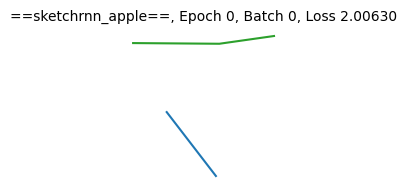

batch_index====== 200
loss.kl=0.03861771151423454, loss.reconstruction=0.6540994644165039, loss.total=0.6734083294868469


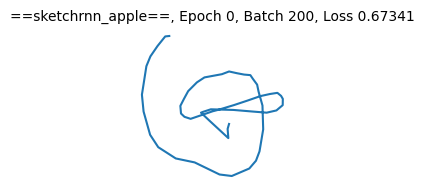

epoch================== 1
batch_index====== 0
loss.kl=0.04678041487932205, loss.reconstruction=0.6073008179664612, loss.total=0.6306910514831543


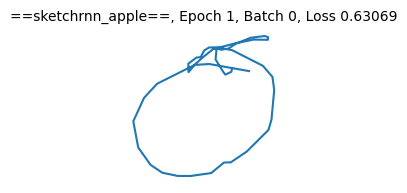

batch_index====== 200
loss.kl=0.05022107809782028, loss.reconstruction=0.407254695892334, loss.total=0.4323652386665344


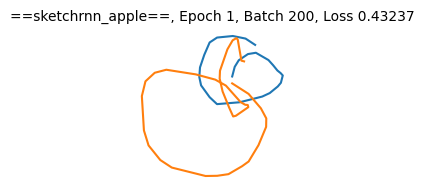

epoch================== 2
batch_index====== 0
loss.kl=0.055142708122730255, loss.reconstruction=0.40936949849128723, loss.total=0.43694084882736206


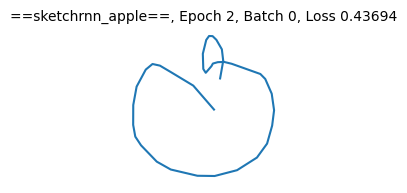

batch_index====== 200
loss.kl=0.06062140688300133, loss.reconstruction=0.41492578387260437, loss.total=0.445236474275589


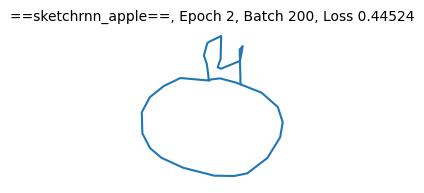

epoch================== 3
batch_index====== 0
loss.kl=0.0657934620976448, loss.reconstruction=0.3482327461242676, loss.total=0.3811294734477997


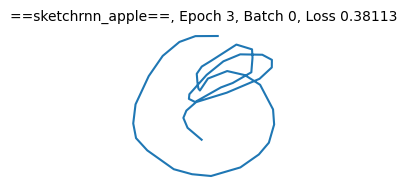

batch_index====== 200
loss.kl=0.07398591190576553, loss.reconstruction=0.3765318691730499, loss.total=0.4135248363018036


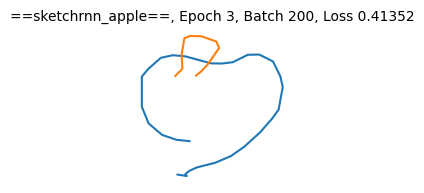

epoch================== 4
batch_index====== 0
loss.kl=0.08309483528137207, loss.reconstruction=0.2236008644104004, loss.total=0.2651482820510864


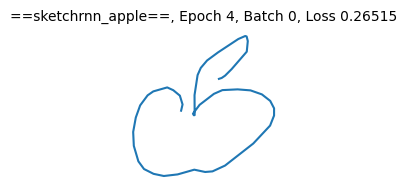

batch_index====== 200
loss.kl=0.08949845284223557, loss.reconstruction=0.32199662923812866, loss.total=0.36674585938453674


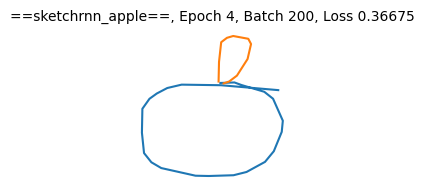

epoch================== 5
batch_index====== 0
loss.kl=0.09614888578653336, loss.reconstruction=0.2365056276321411, loss.total=0.2845800817012787


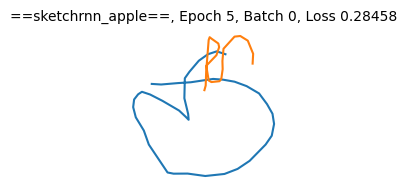

batch_index====== 200
loss.kl=0.1114310622215271, loss.reconstruction=0.21904955804347992, loss.total=0.2747650742530823


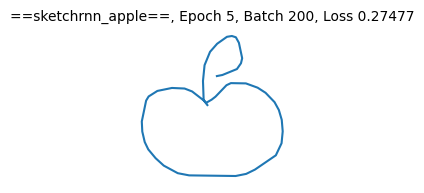

epoch================== 6
batch_index====== 0
loss.kl=0.10383179783821106, loss.reconstruction=0.30137914419174194, loss.total=0.3532950282096863


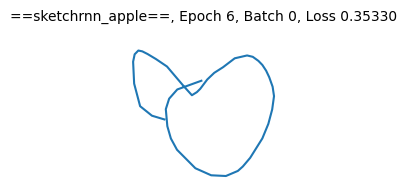

batch_index====== 200
loss.kl=0.13000766932964325, loss.reconstruction=0.2508389353752136, loss.total=0.31584277749061584


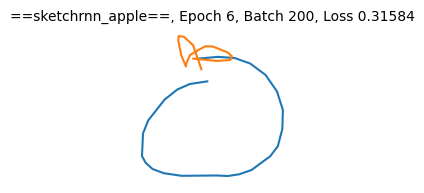

epoch================== 7
batch_index====== 0
loss.kl=0.13618913292884827, loss.reconstruction=0.08836707472801208, loss.total=0.15646164119243622


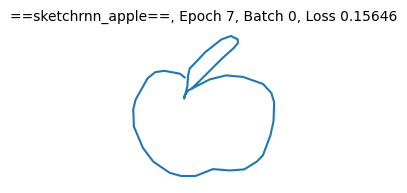

batch_index====== 200
loss.kl=0.14539143443107605, loss.reconstruction=0.08829335123300552, loss.total=0.16098907589912415


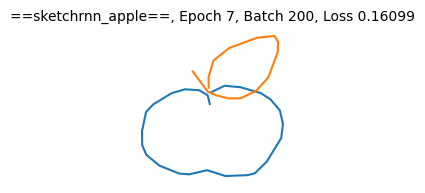

epoch================== 8
batch_index====== 0
loss.kl=0.1422317624092102, loss.reconstruction=0.13736553490161896, loss.total=0.20848141610622406


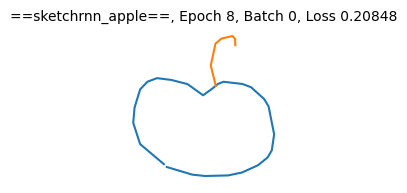

batch_index====== 200
loss.kl=0.15160635113716125, loss.reconstruction=0.11398723721504211, loss.total=0.18979041278362274


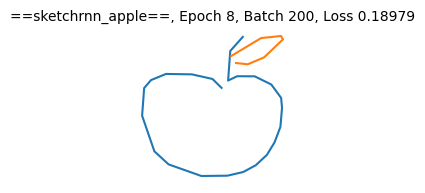

epoch================== 9
batch_index====== 0
loss.kl=0.16093966364860535, loss.reconstruction=0.11750644445419312, loss.total=0.1979762762784958


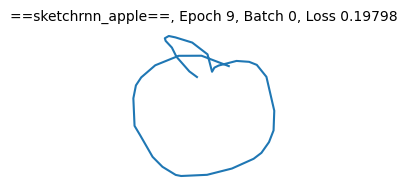

batch_index====== 200
loss.kl=0.1706070601940155, loss.reconstruction=0.08490768074989319, loss.total=0.17021121084690094


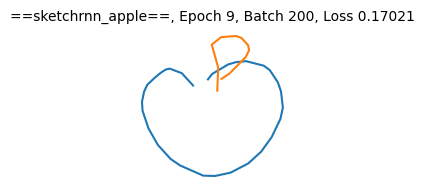

epoch================== 10
batch_index====== 0
loss.kl=0.16405513882637024, loss.reconstruction=0.030180642381310463, loss.total=0.11220820993185043


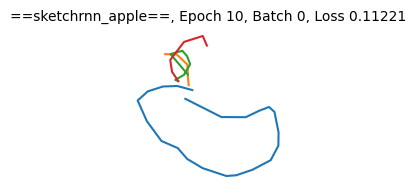

batch_index====== 200
loss.kl=0.17567555606365204, loss.reconstruction=0.14837147295475006, loss.total=0.23620924353599548


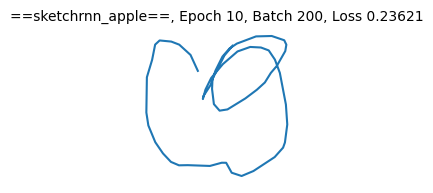

epoch================== 11
batch_index====== 0
loss.kl=0.18276004493236542, loss.reconstruction=0.016771512106060982, loss.total=0.10815153270959854


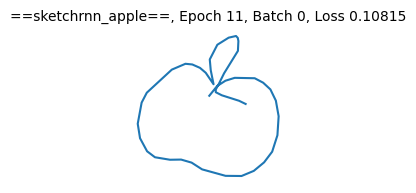

batch_index====== 200
loss.kl=0.18828868865966797, loss.reconstruction=-0.0032450444996356964, loss.total=0.09089930355548859


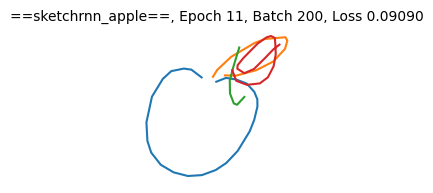

epoch================== 12
batch_index====== 0
loss.kl=0.19384440779685974, loss.reconstruction=-0.02661813423037529, loss.total=0.07030406594276428


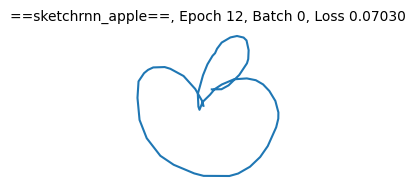

batch_index====== 200
loss.kl=0.19416624307632446, loss.reconstruction=0.006012462079524994, loss.total=0.10309558361768723


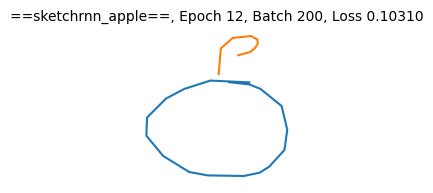

epoch================== 13
batch_index====== 0
loss.kl=0.19514846801757812, loss.reconstruction=0.030140455812215805, loss.total=0.12771469354629517


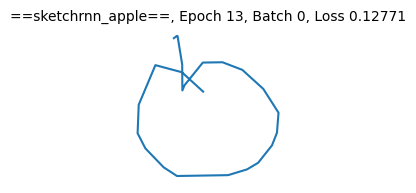

batch_index====== 200
loss.kl=0.20714128017425537, loss.reconstruction=-0.040030479431152344, loss.total=0.06354016065597534


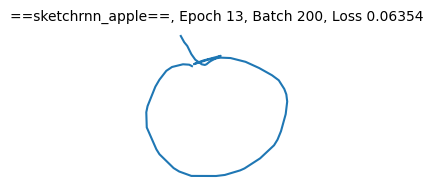

epoch================== 14
batch_index====== 0
loss.kl=0.21293792128562927, loss.reconstruction=-0.012609682977199554, loss.total=0.09385927766561508


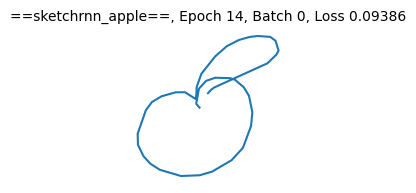

batch_index====== 200
loss.kl=0.22401605546474457, loss.reconstruction=-0.11526362597942352, loss.total=-0.003255598247051239


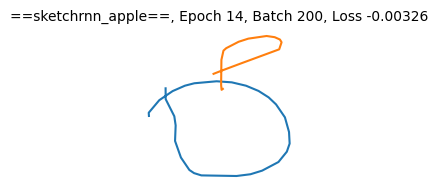

epoch================== 15
batch_index====== 0
loss.kl=0.22417540848255157, loss.reconstruction=-0.07687819004058838, loss.total=0.03520951420068741


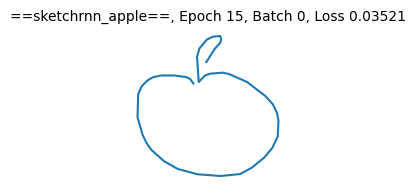

batch_index====== 200
loss.kl=0.2213914394378662, loss.reconstruction=-0.033080779016017914, loss.total=0.07761494070291519


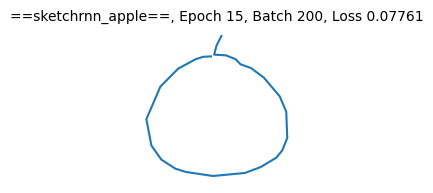

epoch================== 16
batch_index====== 0
loss.kl=0.21244174242019653, loss.reconstruction=-0.09846026450395584, loss.total=0.0077606067061424255


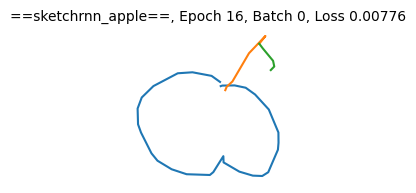

batch_index====== 200
loss.kl=0.22808662056922913, loss.reconstruction=-0.023443810641765594, loss.total=0.09059949964284897


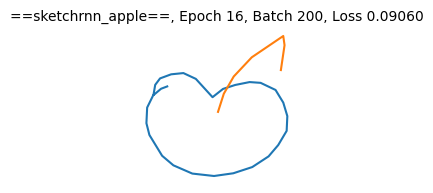

epoch================== 17
batch_index====== 0
loss.kl=0.23598705232143402, loss.reconstruction=-0.1733543872833252, loss.total=-0.055360861122608185


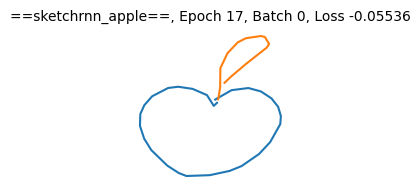

batch_index====== 200
loss.kl=0.23410041630268097, loss.reconstruction=-0.13644175231456757, loss.total=-0.01939154416322708


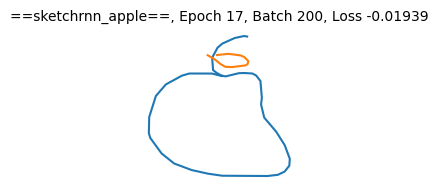

epoch================== 18
batch_index====== 0
loss.kl=0.23326921463012695, loss.reconstruction=-0.08868831396102905, loss.total=0.027946293354034424


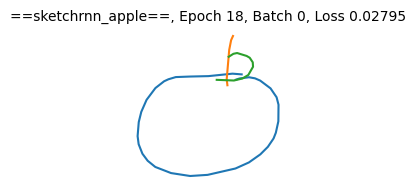

batch_index====== 200
loss.kl=0.2349989265203476, loss.reconstruction=-0.14975836873054504, loss.total=-0.032258905470371246


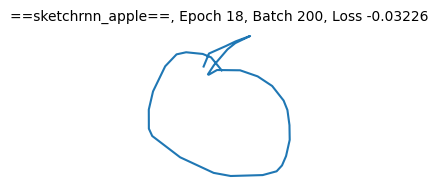

epoch================== 19
batch_index====== 0
loss.kl=0.24264056980609894, loss.reconstruction=-0.11775148659944534, loss.total=0.003568798303604126


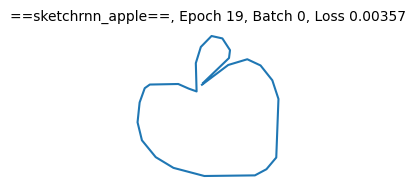

batch_index====== 200
loss.kl=0.23772083222866058, loss.reconstruction=-0.1348828375339508, loss.total=-0.016022421419620514


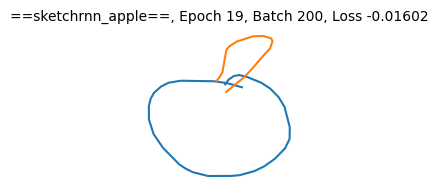

epoch================== 20
batch_index====== 0
loss.kl=0.2547670304775238, loss.reconstruction=-0.07997441291809082, loss.total=0.04740910232067108


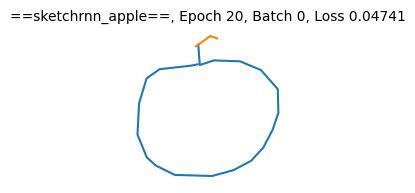

batch_index====== 200
loss.kl=0.26269805431365967, loss.reconstruction=-0.16991855204105377, loss.total=-0.03856952488422394


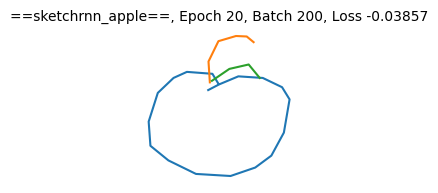

epoch================== 21
batch_index====== 0
loss.kl=0.26992547512054443, loss.reconstruction=-0.21644660830497742, loss.total=-0.0814838707447052


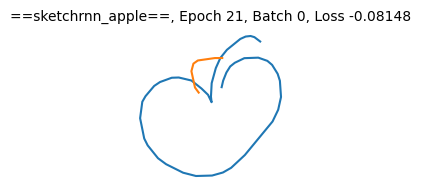

batch_index====== 200
loss.kl=0.256561815738678, loss.reconstruction=-0.13162222504615784, loss.total=-0.0033413171768188477


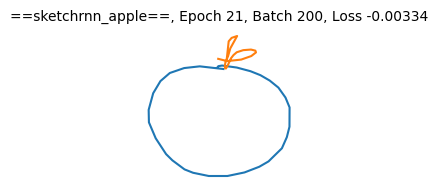

epoch================== 22
batch_index====== 0
loss.kl=0.27898451685905457, loss.reconstruction=-0.1740836352109909, loss.total=-0.03459137678146362


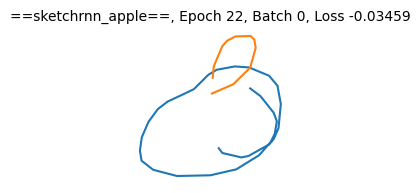

batch_index====== 200
loss.kl=0.2537660300731659, loss.reconstruction=-0.1296740621328354, loss.total=-0.0027910470962524414


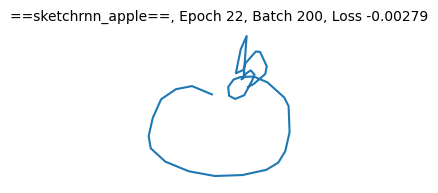

epoch================== 23
batch_index====== 0
loss.kl=0.27078649401664734, loss.reconstruction=-0.23365791141986847, loss.total=-0.0982646644115448


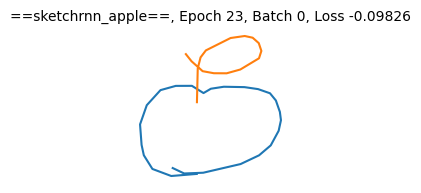

batch_index====== 200
loss.kl=0.2562788128852844, loss.reconstruction=-0.008455038070678711, loss.total=0.1196843683719635


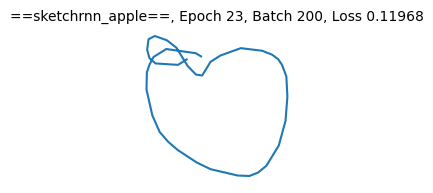

epoch================== 24
batch_index====== 0
loss.kl=0.2909912168979645, loss.reconstruction=-0.2697213888168335, loss.total=-0.12422578036785126


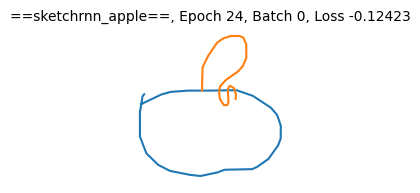

batch_index====== 200
loss.kl=0.3001295328140259, loss.reconstruction=-0.27091991901397705, loss.total=-0.12085515260696411


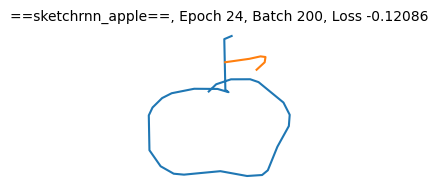

In [16]:
trainer = Trainer('sketchrnn_apple')
trainer.run()

epoch================== 0
batch_index====== 0
loss.kl=0.0007834899006411433, loss.reconstruction=1.6848676204681396, loss.total=1.6852593421936035


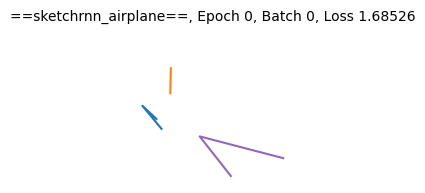

batch_index====== 200
loss.kl=0.01200489979237318, loss.reconstruction=0.5755395889282227, loss.total=0.5815420150756836


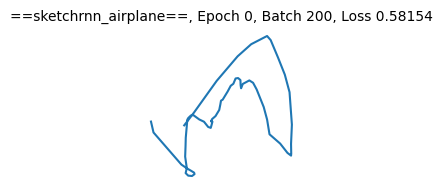

epoch================== 1
batch_index====== 0
loss.kl=0.012815995141863823, loss.reconstruction=0.4752030372619629, loss.total=0.481611043214798


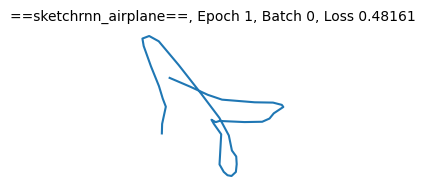

batch_index====== 200
loss.kl=0.017894912511110306, loss.reconstruction=0.39989951252937317, loss.total=0.40884697437286377


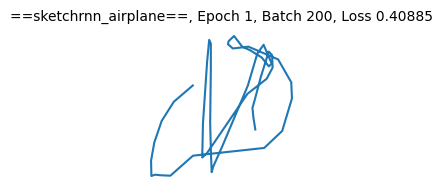

epoch================== 2
batch_index====== 0
loss.kl=0.01945442147552967, loss.reconstruction=0.3844432234764099, loss.total=0.3941704332828522


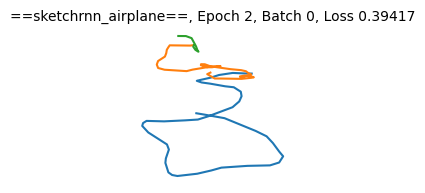

batch_index====== 200
loss.kl=0.026023609563708305, loss.reconstruction=0.4089289903640747, loss.total=0.42194080352783203


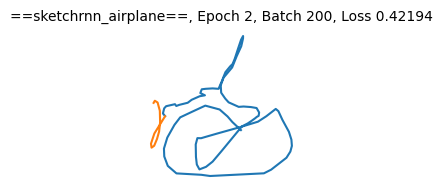

epoch================== 3
batch_index====== 0
loss.kl=0.02949034608900547, loss.reconstruction=0.3036682605743408, loss.total=0.3184134364128113


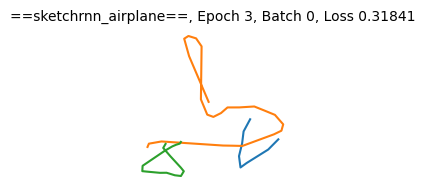

batch_index====== 200
loss.kl=0.03210680931806564, loss.reconstruction=0.25304725766181946, loss.total=0.2691006660461426


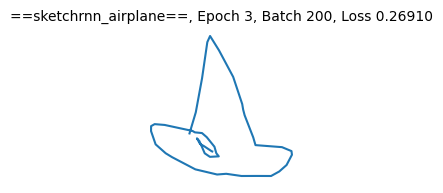

epoch================== 4
batch_index====== 0
loss.kl=0.03444735333323479, loss.reconstruction=0.2203497588634491, loss.total=0.23757342994213104


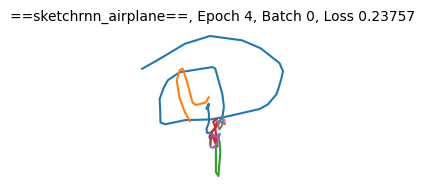

batch_index====== 200
loss.kl=0.03740225359797478, loss.reconstruction=0.2883915603160858, loss.total=0.30709269642829895


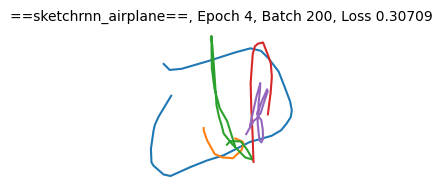

epoch================== 5
batch_index====== 0
loss.kl=0.042433299124240875, loss.reconstruction=0.2882528007030487, loss.total=0.30946946144104004


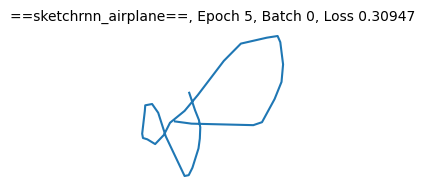

batch_index====== 200
loss.kl=0.049109429121017456, loss.reconstruction=0.1995321661233902, loss.total=0.22408688068389893


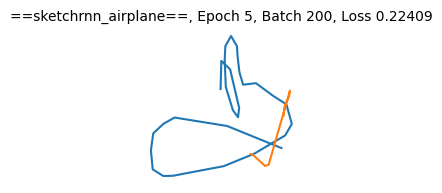

epoch================== 6
batch_index====== 0
loss.kl=0.05770048871636391, loss.reconstruction=0.16464978456497192, loss.total=0.19350002706050873


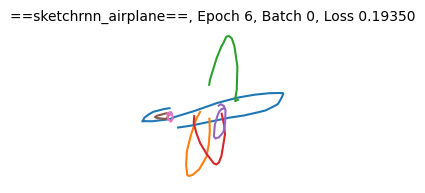

batch_index====== 200
loss.kl=0.0606841966509819, loss.reconstruction=0.16193851828575134, loss.total=0.1922806203365326


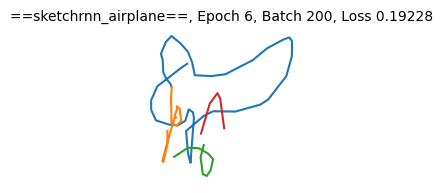

epoch================== 7
batch_index====== 0
loss.kl=0.06804171204566956, loss.reconstruction=0.1762760430574417, loss.total=0.2102968990802765


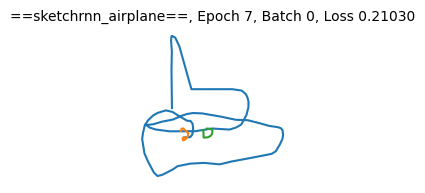

batch_index====== 200
loss.kl=0.07055532187223434, loss.reconstruction=0.18587356805801392, loss.total=0.2211512327194214


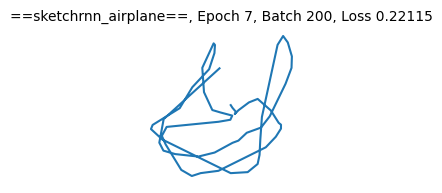

epoch================== 8
batch_index====== 0
loss.kl=0.07636560499668121, loss.reconstruction=0.1684209704399109, loss.total=0.2066037654876709


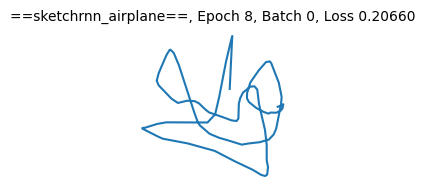

batch_index====== 200
loss.kl=0.09031857550144196, loss.reconstruction=0.20855006575584412, loss.total=0.2537093460559845


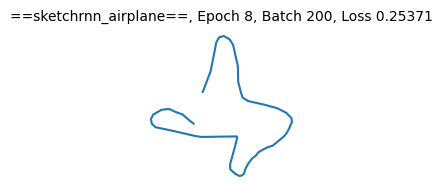

epoch================== 9
batch_index====== 0
loss.kl=0.0867391973733902, loss.reconstruction=0.09125076234340668, loss.total=0.13462036848068237


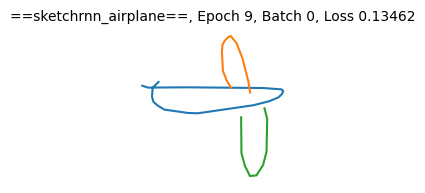

batch_index====== 200
loss.kl=0.09345538914203644, loss.reconstruction=0.10548137873411179, loss.total=0.15220907330513


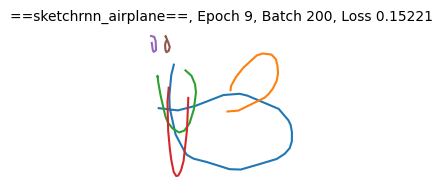

epoch================== 10
batch_index====== 0
loss.kl=0.09603916853666306, loss.reconstruction=0.044247936457395554, loss.total=0.09226752072572708


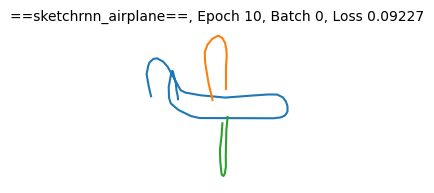

batch_index====== 200
loss.kl=0.10526245087385178, loss.reconstruction=0.0709458738565445, loss.total=0.12357710301876068


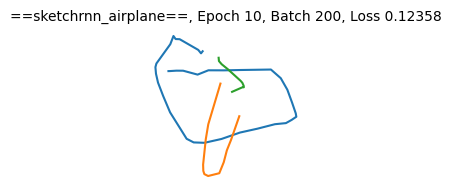

epoch================== 11
batch_index====== 0
loss.kl=0.10336202383041382, loss.reconstruction=0.04742952436208725, loss.total=0.09911053627729416


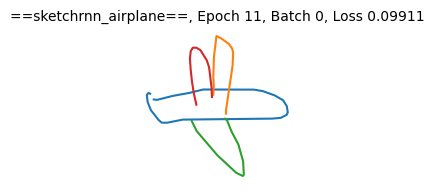

batch_index====== 200
loss.kl=0.10917273163795471, loss.reconstruction=0.09309348464012146, loss.total=0.14767985045909882


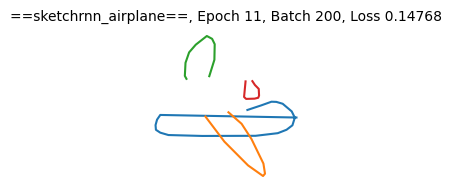

epoch================== 12
batch_index====== 0
loss.kl=0.10993298143148422, loss.reconstruction=0.02634604275226593, loss.total=0.08131253719329834


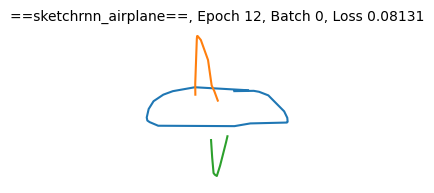

batch_index====== 200
loss.kl=0.11596427857875824, loss.reconstruction=0.04440690949559212, loss.total=0.10238905251026154


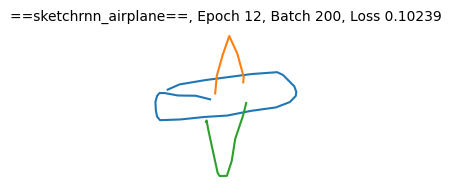

epoch================== 13
batch_index====== 0
loss.kl=0.11372022330760956, loss.reconstruction=0.03443744033575058, loss.total=0.09129755198955536


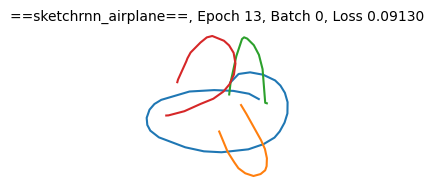

batch_index====== 200
loss.kl=0.11738809943199158, loss.reconstruction=0.010050993412733078, loss.total=0.06874504685401917


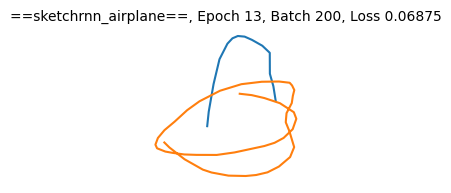

epoch================== 14
batch_index====== 0
loss.kl=0.12450364977121353, loss.reconstruction=0.008663590997457504, loss.total=0.07091541588306427


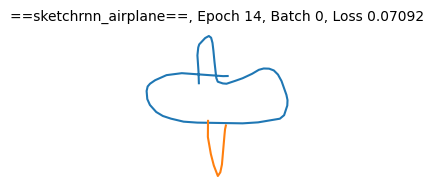

batch_index====== 200
loss.kl=0.11893031001091003, loss.reconstruction=0.06274372339248657, loss.total=0.12220887839794159


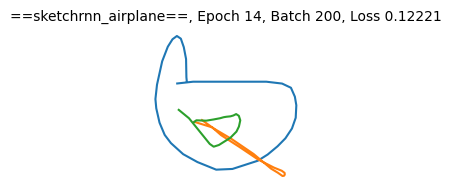

epoch================== 15
batch_index====== 0
loss.kl=0.12316172569990158, loss.reconstruction=0.02955012209713459, loss.total=0.09113098680973053


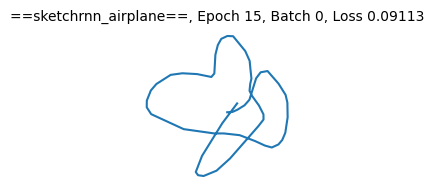

batch_index====== 200
loss.kl=0.12640850245952606, loss.reconstruction=-0.02225690707564354, loss.total=0.04094734415411949


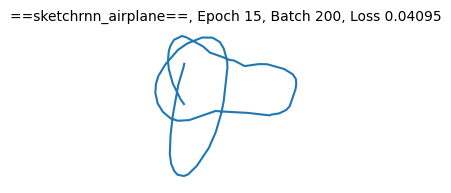

epoch================== 16
batch_index====== 0
loss.kl=0.12595178186893463, loss.reconstruction=-0.07711063325405121, loss.total=-0.014134742319583893


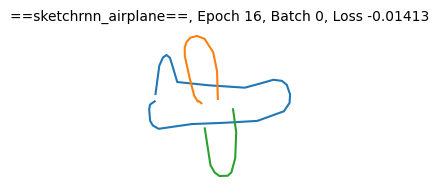

batch_index====== 200
loss.kl=0.1283261477947235, loss.reconstruction=-0.011273492127656937, loss.total=0.05288958176970482


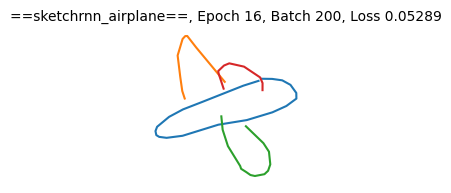

epoch================== 17
batch_index====== 0
loss.kl=0.12753508985042572, loss.reconstruction=-0.023218195885419846, loss.total=0.040549349039793015


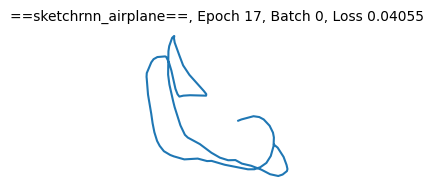

batch_index====== 200
loss.kl=0.125889390707016, loss.reconstruction=0.016513146460056305, loss.total=0.0794578418135643


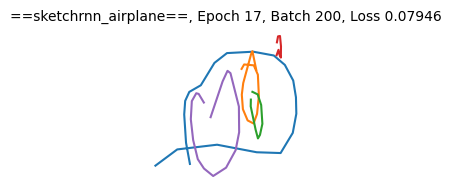

epoch================== 18
batch_index====== 0
loss.kl=0.13569164276123047, loss.reconstruction=-0.016364052891731262, loss.total=0.05148176848888397


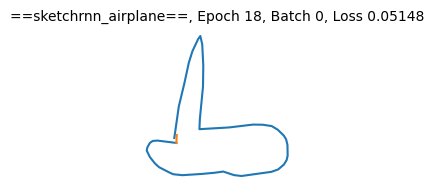

batch_index====== 200
loss.kl=0.13785320520401, loss.reconstruction=-0.013441063463687897, loss.total=0.05548553913831711


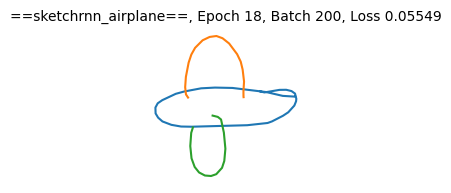

epoch================== 19
batch_index====== 0
loss.kl=0.13613592088222504, loss.reconstruction=-0.04387575387954712, loss.total=0.0241922065615654


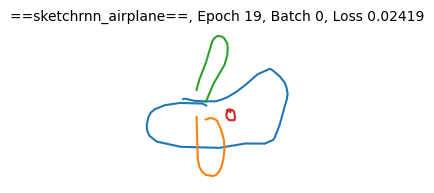

batch_index====== 200
loss.kl=0.1393309086561203, loss.reconstruction=-0.002511013299226761, loss.total=0.06715443730354309


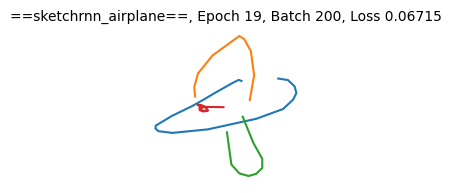

epoch================== 20
batch_index====== 0
loss.kl=0.14622296392917633, loss.reconstruction=-0.04413789138197899, loss.total=0.028973590582609177


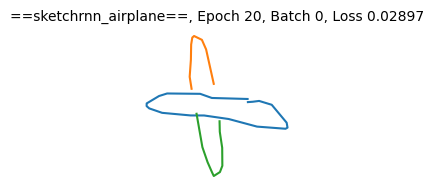

batch_index====== 200
loss.kl=0.1475123018026352, loss.reconstruction=-0.05070602893829346, loss.total=0.02305012196302414


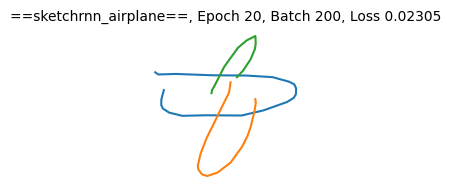

epoch================== 21
batch_index====== 0
loss.kl=0.1409641057252884, loss.reconstruction=-0.02268834039568901, loss.total=0.047793712466955185


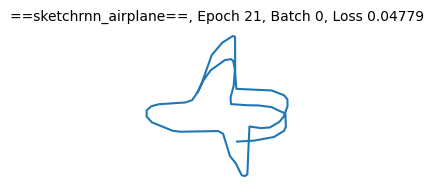

batch_index====== 200
loss.kl=0.14893515408039093, loss.reconstruction=-0.079072967171669, loss.total=-0.004605390131473541


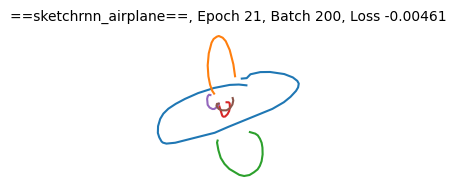

epoch================== 22
batch_index====== 0
loss.kl=0.1480356901884079, loss.reconstruction=-0.013705190271139145, loss.total=0.060312654823064804


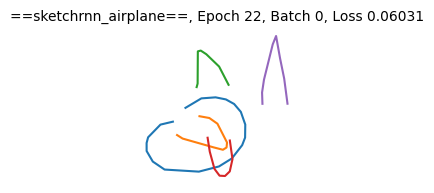

batch_index====== 200
loss.kl=0.1490006297826767, loss.reconstruction=-0.056194666773080826, loss.total=0.018305648118257523


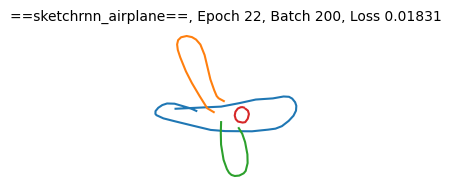

epoch================== 23
batch_index====== 0
loss.kl=0.15465408563613892, loss.reconstruction=-0.0918659120798111, loss.total=-0.014538869261741638


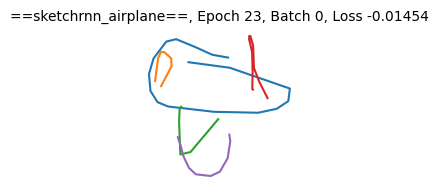

batch_index====== 200
loss.kl=0.14022167026996613, loss.reconstruction=-0.038179509341716766, loss.total=0.031931325793266296


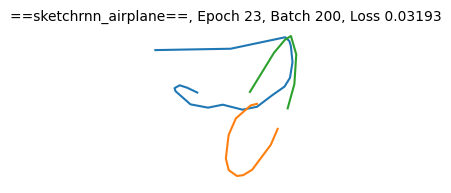

epoch================== 24
batch_index====== 0
loss.kl=0.13772904872894287, loss.reconstruction=-0.02064460888504982, loss.total=0.048219915479421616


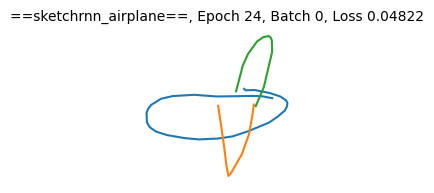

batch_index====== 200
loss.kl=0.15330862998962402, loss.reconstruction=-0.009473662823438644, loss.total=0.06718064844608307


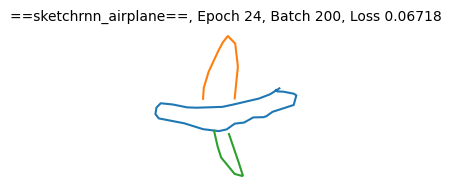

In [15]:
trainer = Trainer('sketchrnn_airplane')
trainer.run()

epoch================== 0
batch_index====== 0
loss.kl=0.0007181323016993701, loss.reconstruction=1.842233657836914, loss.total=1.842592716217041


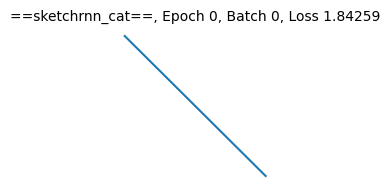

batch_index====== 200
loss.kl=0.008611970581114292, loss.reconstruction=0.6103588342666626, loss.total=0.6146647930145264


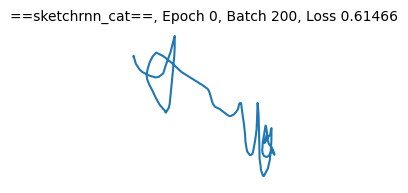

epoch================== 1
batch_index====== 0
loss.kl=0.010581216774880886, loss.reconstruction=0.4732801914215088, loss.total=0.4785707890987396


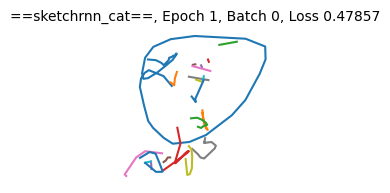

batch_index====== 200
loss.kl=0.01191722135990858, loss.reconstruction=0.3823540210723877, loss.total=0.3883126378059387


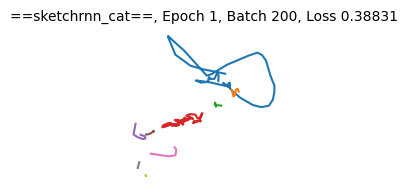

epoch================== 2
batch_index====== 0
loss.kl=0.01272316463291645, loss.reconstruction=0.35073623061180115, loss.total=0.3570978045463562


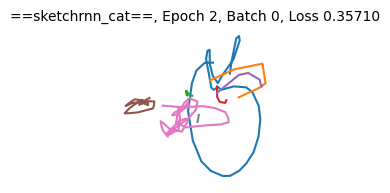

batch_index====== 200
loss.kl=0.011708256788551807, loss.reconstruction=0.29237452149391174, loss.total=0.2982286512851715


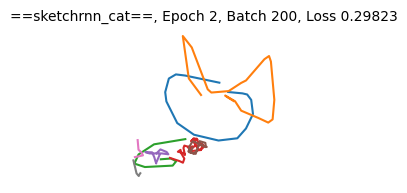

epoch================== 3
batch_index====== 0
loss.kl=0.015783991664648056, loss.reconstruction=0.2732369601726532, loss.total=0.2811289429664612


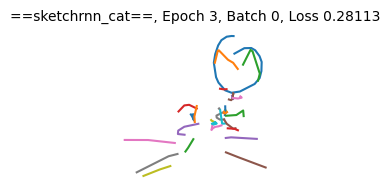

batch_index====== 200
loss.kl=0.017062850296497345, loss.reconstruction=0.28983402252197266, loss.total=0.29836544394493103


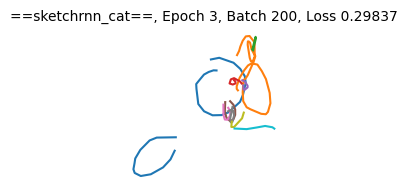

epoch================== 4
batch_index====== 0
loss.kl=0.019253501668572426, loss.reconstruction=0.2618706524372101, loss.total=0.2714973986148834


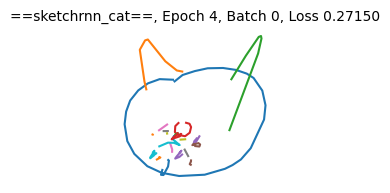

batch_index====== 200
loss.kl=0.022180739790201187, loss.reconstruction=0.2467537224292755, loss.total=0.25784409046173096


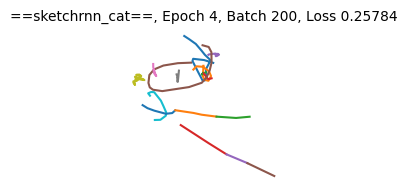

epoch================== 5
batch_index====== 0
loss.kl=0.022478660568594933, loss.reconstruction=0.21134495735168457, loss.total=0.2225842922925949


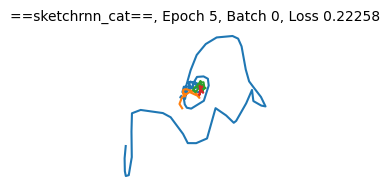

batch_index====== 200
loss.kl=0.026763932779431343, loss.reconstruction=0.14589007198810577, loss.total=0.15927204489707947


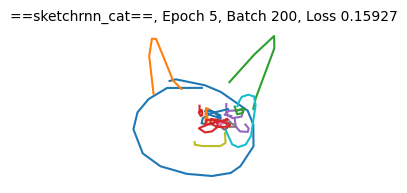

epoch================== 6
batch_index====== 0
loss.kl=0.028361205011606216, loss.reconstruction=0.16445663571357727, loss.total=0.17863723635673523


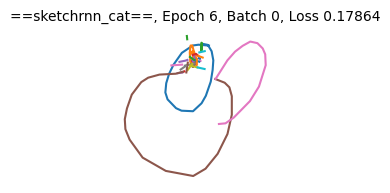

batch_index====== 200
loss.kl=0.03339342400431633, loss.reconstruction=0.18577663600444794, loss.total=0.20247334241867065


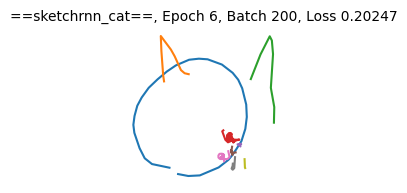

epoch================== 7
batch_index====== 0
loss.kl=0.031942468136548996, loss.reconstruction=0.16467277705669403, loss.total=0.18064400553703308


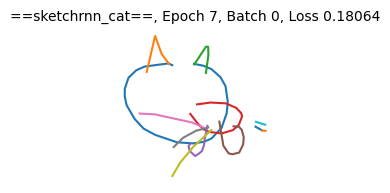

batch_index====== 200
loss.kl=0.036446698009967804, loss.reconstruction=0.1423776000738144, loss.total=0.160600945353508


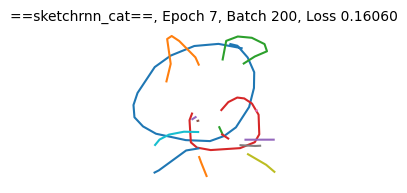

epoch================== 8
batch_index====== 0
loss.kl=0.041465580463409424, loss.reconstruction=0.17694903910160065, loss.total=0.19768182933330536


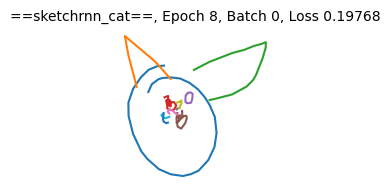

batch_index====== 200
loss.kl=0.04461213946342468, loss.reconstruction=0.1233920082449913, loss.total=0.14569807052612305


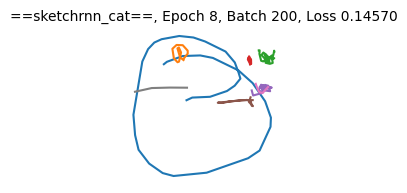

epoch================== 9
batch_index====== 0
loss.kl=0.04802446439862251, loss.reconstruction=0.13091349601745605, loss.total=0.15492573380470276


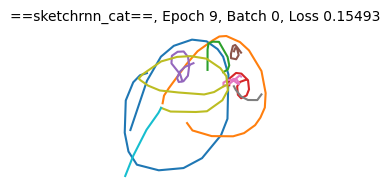

batch_index====== 200
loss.kl=0.04787256941199303, loss.reconstruction=0.11818162351846695, loss.total=0.14211790263652802


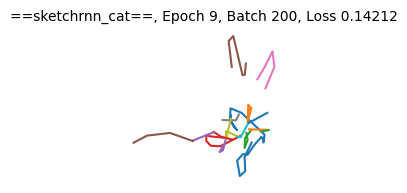

epoch================== 10
batch_index====== 0
loss.kl=0.05351804941892624, loss.reconstruction=0.05790073424577713, loss.total=0.08465975522994995


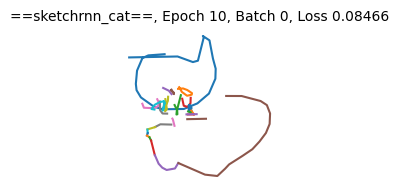

batch_index====== 200
loss.kl=0.06002097576856613, loss.reconstruction=0.10070330649614334, loss.total=0.1307137906551361


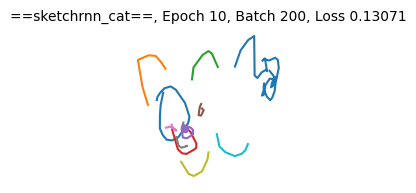

epoch================== 11
batch_index====== 0
loss.kl=0.06185982748866081, loss.reconstruction=0.07333971560001373, loss.total=0.10426963120698929


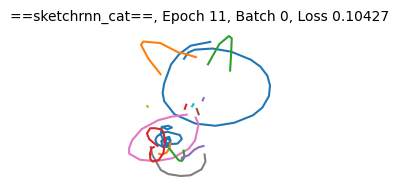

batch_index====== 200
loss.kl=0.06646227836608887, loss.reconstruction=0.04434455558657646, loss.total=0.0775756984949112


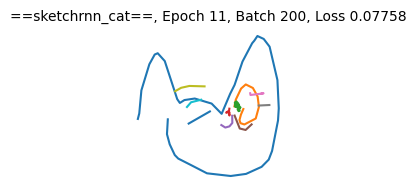

epoch================== 12
batch_index====== 0
loss.kl=0.06898852437734604, loss.reconstruction=0.08275354653596878, loss.total=0.1172478049993515


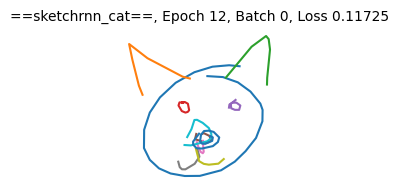

batch_index====== 200
loss.kl=0.06649124622344971, loss.reconstruction=0.044780515134334564, loss.total=0.07802613824605942


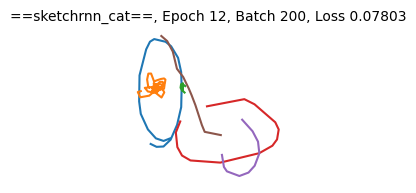

epoch================== 13
batch_index====== 0
loss.kl=0.06951606273651123, loss.reconstruction=0.045876920223236084, loss.total=0.0806349515914917


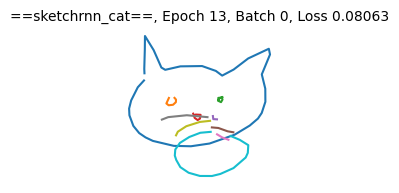

batch_index====== 200
loss.kl=0.07590561360120773, loss.reconstruction=0.07551062107086182, loss.total=0.11346343159675598


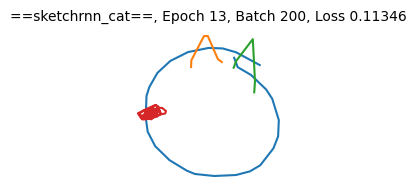

epoch================== 14
batch_index====== 0
loss.kl=0.07914871722459793, loss.reconstruction=0.05073310062289238, loss.total=0.09030745923519135


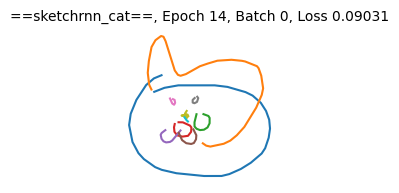

batch_index====== 200
loss.kl=0.08051548898220062, loss.reconstruction=0.028805814683437347, loss.total=0.06906355917453766


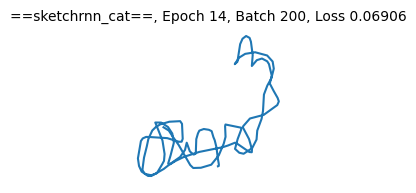

epoch================== 15
batch_index====== 0
loss.kl=0.08335847407579422, loss.reconstruction=0.01472509279847145, loss.total=0.05640432983636856


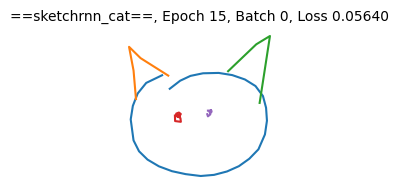

batch_index====== 200
loss.kl=0.08769345283508301, loss.reconstruction=0.03774358332157135, loss.total=0.08159030973911285


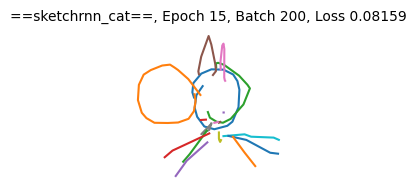

epoch================== 16
batch_index====== 0
loss.kl=0.08864760398864746, loss.reconstruction=-0.0040991418063640594, loss.total=0.04022466018795967


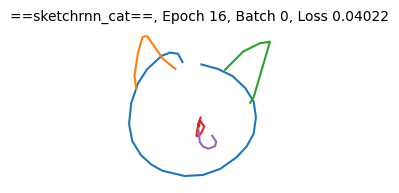

batch_index====== 200
loss.kl=0.09069468080997467, loss.reconstruction=0.04920917749404907, loss.total=0.09455651789903641


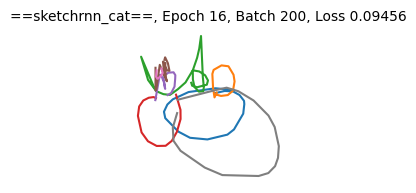

epoch================== 17
batch_index====== 0
loss.kl=0.09805537760257721, loss.reconstruction=0.005863107740879059, loss.total=0.054890796542167664


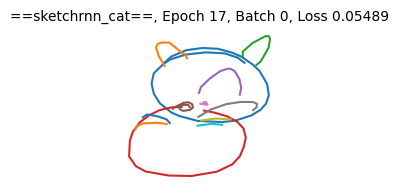

batch_index====== 200
loss.kl=0.0932837501168251, loss.reconstruction=-0.04556364193558693, loss.total=0.0010782331228256226


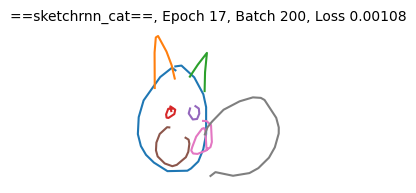

epoch================== 18
batch_index====== 0
loss.kl=0.09730901569128036, loss.reconstruction=-0.009184114634990692, loss.total=0.03947039321064949


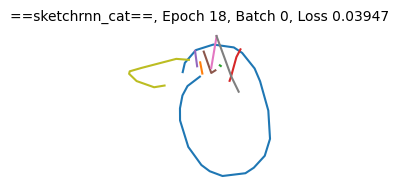

batch_index====== 200
loss.kl=0.09741628170013428, loss.reconstruction=-0.04363064095377922, loss.total=0.005077499896287918


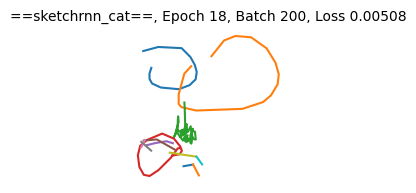

epoch================== 19
batch_index====== 0
loss.kl=0.09950552135705948, loss.reconstruction=-0.03469175472855568, loss.total=0.01506100594997406


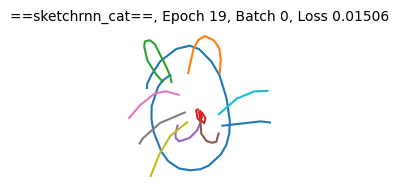

batch_index====== 200
loss.kl=0.10176696628332138, loss.reconstruction=-0.023394625633955002, loss.total=0.02748885750770569


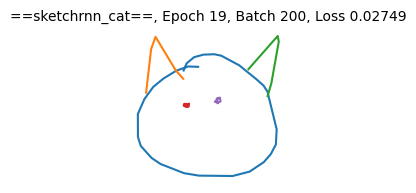

epoch================== 20
batch_index====== 0
loss.kl=0.09990556538105011, loss.reconstruction=-0.0073595717549324036, loss.total=0.04259321093559265


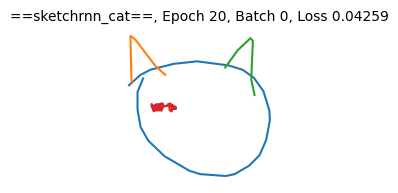

batch_index====== 200
loss.kl=0.10486824065446854, loss.reconstruction=-0.05320977047085762, loss.total=-0.000775650143623352


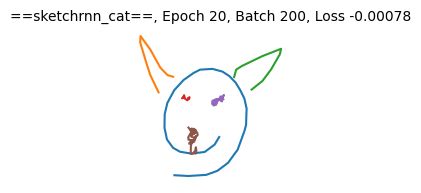

epoch================== 21
batch_index====== 0
loss.kl=0.10363326966762543, loss.reconstruction=-0.05860104411840439, loss.total=-0.006784409284591675


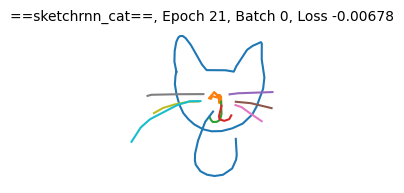

batch_index====== 200
loss.kl=0.10819735378026962, loss.reconstruction=-0.029350701719522476, loss.total=0.024747975170612335


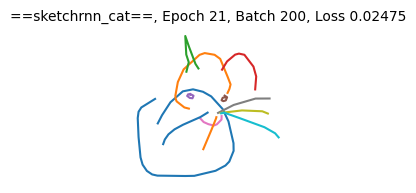

epoch================== 22
batch_index====== 0
loss.kl=0.10653331875801086, loss.reconstruction=-0.05788416787981987, loss.total=-0.004617508500814438


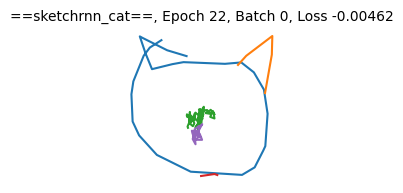

batch_index====== 200
loss.kl=0.10891756415367126, loss.reconstruction=-0.12057389318943024, loss.total=-0.0661151111125946


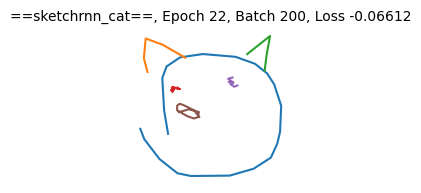

epoch================== 23
batch_index====== 0
loss.kl=0.11370149254798889, loss.reconstruction=-0.05840356647968292, loss.total=-0.0015528202056884766


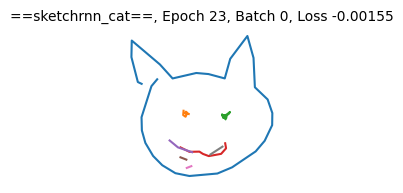

batch_index====== 200
loss.kl=0.10924655944108963, loss.reconstruction=-0.05434706062078476, loss.total=0.00027621909976005554


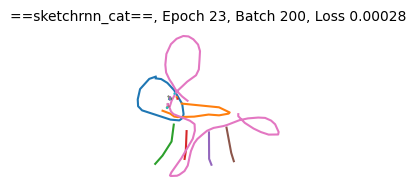

epoch================== 24
batch_index====== 0
loss.kl=0.11201516538858414, loss.reconstruction=-0.06609352678060532, loss.total=-0.010085944086313248


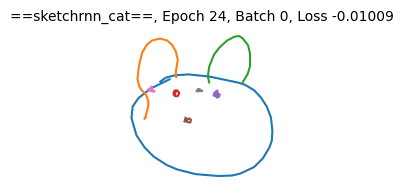

batch_index====== 200
loss.kl=0.11380136013031006, loss.reconstruction=-0.06608009338378906, loss.total=-0.009179413318634033


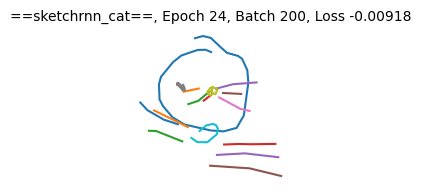

In [14]:
trainer = Trainer('sketchrnn_cat')
trainer.run()